In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2 as cv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2024-11-26 11:01:52.116951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732615312.303021     860 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732615312.349549     860 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 11:01:52.679146: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
images_csv = pd.read_csv('data.csv')

In [3]:
images_csv = images_csv[['path', 'label']]
images_csv.head()

,path,label
0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,Surprise
1,Surprise/cropped_emotions.100096~12fffff.png,Surprise
2,Surprise/0df0e470e33093f5b72a8197fa209d684032c...,Surprise
3,Surprise/cropped_emotions.260779~12fffff.png,Surprise
4,Surprise/cropped_emotions.263616~12fffff.png,Surprise


In [4]:
to_drop = images_csv[images_csv["label"] == "Ahegao"].index
images_csv = images_csv.drop(to_drop)

In [5]:
emotions = images_csv['label'].unique()
emotions_dic = {}
for index, emotion in enumerate(emotions):
    emotions_dic[emotion] = index

print(emotions_dic)

{'Surprise': 0, 'Sad': 1, 'Happy': 2, 'Neutral': 3, 'Angry': 4}


In [6]:
e_images = images_csv.replace(emotions_dic)

/tmp/ipykernel_860/2357465474.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  e_images = images_csv.replace(emotions_dic)


In [7]:
Sizes = []
for i in e_images['path']:
    image = cv.imread(f'dataset/{i}')
    height = image.shape[0]
    width = image.shape[1]
    Sizes.append(height*width)

In [8]:
e_images.insert(2, 'Sizes', Sizes)

In [9]:
diffrence = 100000
photo_filter = (e_images['Sizes'] >= diffrence)
e_images_filtered = e_images.loc[photo_filter]
e_images_filtered

,path,label,Sizes
0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,0,230400
4,Surprise/cropped_emotions.263616~12fffff.png,0,187833
7,Surprise/0a15c44d8be6cc71cd9d8ab595266e5147459...,0,459684
9,Surprise/cropped_emotions.263517~12fffff.png,0,166160
10,Surprise/cropped_emotions.265653~12fffff.png,0,128310
...,...,...,...
15439,Angry/cropped_emotions.571531~angry.png,4,412125
15440,Angry/cropped_emotions.157999~angry.png,4,106110
15441,Angry/cropped_emotions.231380~angry.png,4,194530
15442,Angry/cropped_emotions.232172~angry.png,4,350620


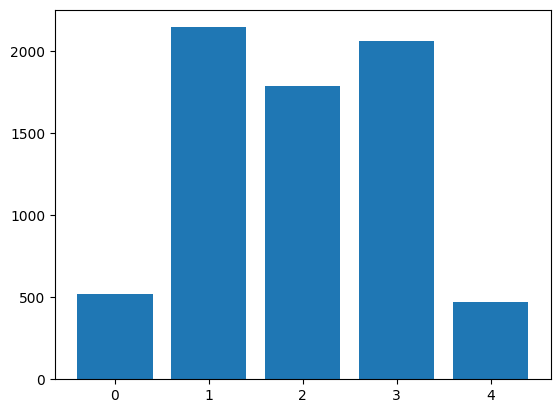

In [10]:
photos_by_emotions = e_images_filtered.groupby('label').count()
plt.bar(photos_by_emotions.index, photos_by_emotions['path']);

In [11]:
X = e_images_filtered['path']
y = e_images_filtered['label']

In [12]:
X_images = []
for i in X:
    image = cv.imread(f'dataset/{i}')
    rgb_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    resize_image = cv.resize(rgb_image, (100, 100))
    std_image = resize_image / 255.0
    X_images.append(std_image)

X_images_np = np.array(X_images).astype(dtype='float32')
y_np = y.to_numpy().astype(dtype='long')

In [13]:
Images = []
for image in range(5):
    index = np.where(y_np == image)[0][0]
    Images.append(X_images_np[index])

In [14]:
Images[0].shape

(100, 100, 3)

/tmp/ipykernel_860/4104482281.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


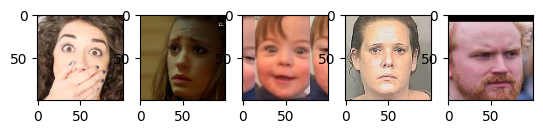

In [15]:
fig, axs = plt.subplots(1,5)

for index, ax in enumerate(axs.ravel()):
    ax.imshow(Images[index])
    
fig.show()

In [16]:
X_images_np.shape

(6975, 100, 100, 3)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_images_np, y_np, test_size=0.3, random_state=123, stratify=y)

In [18]:
X_train.shape

(4882, 100, 100, 3)

In [19]:
y_train

array([3, 1, 3, ..., 3, 3, 1])

In [20]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

In [21]:
model = Sequential()
model.add(Conv2D(10, (10, 10), activation = 'relu', input_shape=(100, 100, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(20, (10, 10), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(500, activation = 'relu'))
model.add(Dense(5, activation = 'log_softmax'))

/home/adam/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1732615543.675121     860 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4701 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1


In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 91, 91, 10)     │         3,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 45, 45, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 36, 36, 20)     │        20,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 18, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6480)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │     3,240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,266,035 (12.46 MB)

 Trainable params: 3,266,035 (12.46 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [24]:
history = model.fit(X_train, y_train, epochs=10)

2024-11-26 11:05:46.176759: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 585840000 exceeds 10% of free system memory.
2024-11-26 11:05:47.172473: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 585840000 exceeds 10% of free system memory.


Epoch 1/10


I0000 00:00:1732615550.850788    1416 service.cc:148] XLA service 0x7f110c00a600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732615550.851934    1416 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 with Max-Q Design, Compute Capability 6.1
2024-11-26 11:05:50.929904: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732615551.154667    1416 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/153 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.0764 - loss: 1.8291

I0000 00:00:1732615557.815645    1416 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.3176 - loss: 1.4802
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5040 - loss: 1.1719
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5728 - loss: 1.0129
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6205 - loss: 0.9490
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.6573 - loss: 0.8218
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.7221 - loss: 0.6945
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.7949 - loss: 0.5299
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.8672 - loss: 0.3450
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9251 - loss: 0.2296
Epoch 10/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.9615 - loss: 0.1200


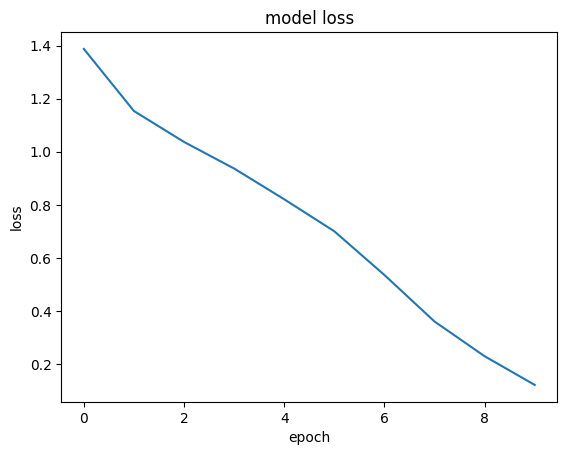

In [25]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [26]:
np.exp(model.predict(np.array([X_train[0]])))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[0.21904454, 0.26811397, 0.01333405, 0.4854255 , 0.01408193]],
      dtype=float32)

In [27]:
y_train[0]

np.int64(3)

In [28]:
model.evaluate(X_test, y_test)

2024-11-26 11:07:02.202248: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 251160000 exceeds 10% of free system memory.
2024-11-26 11:07:02.817997: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 251160000 exceeds 10% of free system memory.


66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5658 - loss: 1.9246


[2.072847366333008, 0.5642618536949158]

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [30]:
y_pred = np.exp(model.predict(X_test))

2024-11-26 11:07:08.605084: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 251160000 exceeds 10% of free system memory.


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


In [31]:
y_pred

array([[3.6438203e-13, 3.2479595e-04, 3.1179201e-02, 9.6849602e-01,
        6.7191137e-16],
       [7.4284357e-01, 8.3826639e-02, 3.5037920e-10, 1.7332973e-01,
        8.0819696e-08],
       [1.2221765e-09, 9.9957991e-01, 2.7232074e-05, 3.8817528e-04,
        4.5442571e-06],
       ...,
       [4.9007753e-08, 3.9414698e-01, 3.8667154e-04, 5.9593016e-01,
        9.5361350e-03],
       [1.2296438e-03, 3.1954754e-02, 3.3193763e-05, 9.6675289e-01,
        2.9563860e-05],
       [3.1392297e-05, 5.0851244e-01, 2.6448902e-01, 2.2685026e-01,
        1.1683893e-04]], dtype=float32)

In [32]:
y_pred_max = np.argmax(y_pred, axis=1)

In [33]:
y_pred_max

array([3, 0, 1, ..., 3, 3, 1])

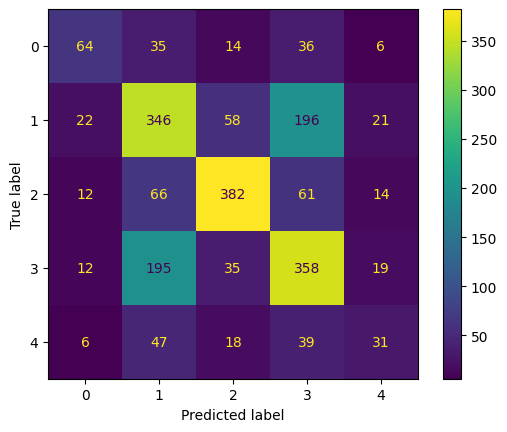

In [34]:
matrix = confusion_matrix(y_test, y_pred_max)
ConfusionMatrixDisplay(matrix).plot()
plt.show()

In [142]:
@tf.function(input_signature=[tf.TensorSpec(shape=(None), dtype=tf.string)])
def pre_and_pro_process(images_bytes):
    def preprocess(image_bytes):
        image = tf.image.decode_image(image_bytes, channels=3, expand_animations = False)
        image = tf.image.resize(image, [100, 100])
        image = image / 255.0

        return image

    images = tf.map_fn(preprocess, images_bytes, dtype=tf.float32)

    predictions = model(images)

    output = []
    for batch in predictions:
        index = 0
        for emotion_prob in batch:
            #output.append({"classes": "1", "scores": tf.math.exp(emotion_prob)})
            #output.append({"classes": "1", "scores": 1})
            return tf.math.exp(emotion_prob).numpy()
            #index += 1
    #return output

In [130]:
#model.export("model_store_tf/1/")

In [37]:
#import os
#os.path.abspath("model_store_tf/model.keras")

In [41]:
#import json

In [43]:
#request = json.dumps({"instances": X_train[0].tolist()})

In [123]:
with open("happy.jpg", "rb") as image_file:
  a = image_file.read()
  b = bytes(a)

In [143]:
pre_and_pro_process([b, b])

AttributeError: in user code:

    File "/tmp/ipykernel_860/2205726194.py", line 20, in pre_and_pro_process  *
        return tf.math.exp(emotion_prob).numpy()

    AttributeError: 'SymbolicTensor' object has no attribute 'numpy'
